## Рекомендательные системы: предсказание оценки

Рассмотрим задачу предсказания оценки, которую пользователь поставит фильму. Особенность этой задачи в том, что объекты выборки описываются категориальными признаками, принимающими большое число значений (например: идентификатор пользователя, идентификатор фильма, тэги, киноперсоны).

Данные: [MovieLens + IMDb/Rotten Tomatoes](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip) ([описание](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt)). Набор содержит данные о предпочтениях пользователей сервиса рекомендации кинофильмов [MovieLens](http://www.movielens.org/). Пользовательские оценки для фильмов принимают значения в интервале от 0.5 до 5.0, они записаны в файле *user_ratedmovies.dat* (а также в *user_ratedmovies-timestamps.dat*,  где для каждой оценки записана дата и время в формате timestamp), остальные файлы содержат дополнительную информацию о фильмах, которую можно использовать как признаки. Заметьте: кроме оценок (и тегов), про пользователя ничего не известно.

Задача: построить модель, предсказывающую оценку пользователя фильму, который он еще не смотрел.

Метрика качества: будем считать, что пользователю сервиса доступен блок рекомендаций, который может содержать рекомендации не более чем 5 фильмов.
Выберем некоторого пользователя $u$ и обозначим известные для него рейтинги за $R^u$. В качестве тестовых рейтингов $R^u_{test}$ для этого пользователя рассмотрим 5 рейтингов, поставленные последними по времени, в качестве валидационных $R^u_{val}$ — предпоследние 5 рейтингов. Остальные известные рейтинги этого пользователя будут составлять обучающую выборку $R^u_{train}$.
Для подбора гиперпараметров в рамках данного задания будем использовать валидационную выборку, предварительно обучив модель на обучающей выборке, а для финальной оценки качества — тестовую выборку, предварительно обучив модель на обучающей и валидационной выборках.

**1. (1 балл)** Загрузите данные и сформируйте 3 разреженные матрицы пользователи—фильмы для обучающих, валидационных и тестовых рейтингов пользователей соответственно, где в каждой ячейке стоит рейтинг, если он известен, или ноль, если неизвестен.

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from collections import Counter
import matplotlib.pyplot as plt
import scipy as sc
from tqdm import tqdm
%matplotlib inline
from tqdm import tqdm_notebook

In [2]:
user_rate = pd.read_csv('user_ratedmovies-timestamps.dat', sep='\t')

In [3]:
user_rate.head()

,userID,movieID,rating,timestamp
0,75,3,1.0,1162160236000
1,75,32,4.5,1162160624000
2,75,110,4.0,1162161008000
3,75,160,2.0,1162160212000
4,75,163,4.0,1162160970000


#### Сформируем 3 разреженные матрицы пользователи - фильмы для обучающих, валидационных и тестовых рейтингов пользователей соответственно, где в каждой ячейке стоит рейтинг, если он известен, или ноль, если неизвестен.

умножим рейтинги на 2, чтобы преобразования выполнялись быстрее, тк станут типа int и вернем к исходному виду после преобразования

In [4]:
user_rate.rating = user_rate.rating * 2 
user_rate.head()

,userID,movieID,rating,timestamp
0,75,3,2.0,1162160236000
1,75,32,9.0,1162160624000
2,75,110,8.0,1162161008000
3,75,160,4.0,1162160212000
4,75,163,8.0,1162160970000


In [5]:
user_rate = user_rate.sort_values(by='timestamp',axis=0)
user_rate.head()

,userID,movieID,rating,timestamp
628154,51198,608,10.0,874532420000
628167,51198,1073,8.0,874532466000
628132,51198,141,8.0,874532518000
628141,51198,356,8.0,874532624000
628180,51198,1198,10.0,874532675000


In [6]:
unique_users = user_rate.userID.unique()

In [7]:
train_matrix_start = user_rate[user_rate.userID == unique_users[0]][:-10]
valid_matrix_start = user_rate[user_rate.userID == unique_users[0]][-10:-5]
test_matrix_start = user_rate[user_rate.userID == unique_users[0]][-5:]

In [8]:
for user in tqdm_notebook(range(1,len(unique_users))):
    train_matrix_start = pd.concat([train_matrix_start,user_rate[user_rate.userID == unique_users[user]][:-10]])
    valid_matrix_start = pd.concat([valid_matrix_start,user_rate[user_rate.userID == unique_users[user]][-10:-5]])
    test_matrix_start = pd.concat([test_matrix_start,user_rate[user_rate.userID == unique_users[user]][-5:]])

A Jupyter Widget

In [9]:
train_matrix_start.shape, valid_matrix_start.shape, test_matrix_start.shape

((834468, 4), (10565, 4), (10565, 4))

##### Функция для формирования матрицы

In [10]:
def form_matrix(full_zero_ratings_matrix,suitable_ratings_matrix):
    info = {}
    matrix = full_zero_ratings_matrix.copy()
    matrix['rating'] = 0
    info.update({'shape of dateframe with indexes':suitable_ratings_matrix.shape}) 
    indexes = suitable_ratings_matrix.index
    
    for index in tqdm_notebook(range(len(indexes))):
        matrix['rating'][indexes[index]] = suitable_ratings_matrix['rating'][indexes[index]]
    info.update({'number of non zero elements in result dataframe':len(matrix.rating[matrix.rating!=0])})
    
    matrix.rating = matrix.rating / 2
    matrix = matrix.pivot(values= 'rating',index= 'userID', columns= 'movieID')
    
    matrix = matrix.fillna(0)
    matrix = matrix.as_matrix()
    return matrix, info

#### Формируем обучающую матрицу

In [11]:
train_matrix, train_matrix_info = form_matrix(user_rate,train_matrix_start)

A Jupyter Widget

In [12]:
train_matrix

array([[ 0. ,  0. ,  1. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       ..., 
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 4.5,  0. ,  2. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

#### Формируем валидационнную матрицу

In [13]:
valid_matrix, valid_matrix_start = form_matrix(user_rate,valid_matrix_start)

A Jupyter Widget

In [14]:
valid_matrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

#### Формируем тестувую матрицу

In [15]:
test_matrix, test_matrix_info = form_matrix(user_rate,test_matrix_start)

A Jupyter Widget

Качество рекомендаций: будем использовать метрики RMSE@k и nDCG@k для $k=5$, описанные ниже.

#### RMSE@k

Поскольку нас интересуют лишь фильмы, попавшие в блок рекомендаций, качество работы модели можно оценивать при помощи RMSE на $k$ фильмах с наибольшим предсказанным рейтингом, где $k$ — размер блока рекомендаций. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}$. Тогда RMSE@k:

$$ \text{RMSE@k}(u) = \sqrt{ \frac{1}{k} \sum_{i=1}^k (r_{u(i)} - \hat{r}_{u(i)})^2 },$$
$$ \text{RMSE@k} = \frac{1}{|U|} \sum_{u \in U} \text{RMSE@k}(u),$$
где $U$ — множество пользователей. При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

#### nDCG@k

Также можно использовать метрику качества ранжирования. Для этого для каждого пользователя $u$ предскажем оценку для всех фильмов из $R^u_{test}$ и отсортируем эти фильмы по убыванию предсказанного рейтинга. Ожидается, что хороший алгоритм должен выдать релевантные фильмы вверху списка. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}.$

Тогда nDCG@k :

$$\text{DCG@k}(u) = \sum_{i=1}^k g(r_{u(i)}) d(i),$$
$$\text{nDCG@k}(u) = \frac{\text{DCG@k}(u)}{\max \text{DCG@k}(u)},$$
$$\text{nDCG@k} = \frac{1}{|U|} \sum_{u \in U} \text{nDCG@k}(u),$$
где $g(r)$ — функция полезности фильма, а  $d(i)$ — штраф за позицию.

Положим $g(r) = 2^r-1, \, d(i) = \frac{1}{\log_2 (i+1)}.$ При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

**2. (2 балла)** Реализуйте функции rmse_score и ndcg_score, вычисляющие значения описанных выше метрик. Каждая из функций в качестве параметров должна принимать:
 * y_true — матрицу тестовых рейтингов (сформированную аналогично матрице тестовых рейтингов из предыдущего пункта; функция должна корректно работать и для разреженных, и для плотных матриц);
 * y_predicted — матрицу предсказаний модели в аналогичном формате (функция должна корректно работать и для разреженных, и для плотных матриц);
 * k — параметр $k$ в определениях метрик.

##### rmse score

In [16]:
def rmse_score(y_true, y_predicted, k=5):   
    matrix_types = [np.ndarray, sparse.csr_matrix]
    if type(y_true) in matrix_types and type(y_predicted) in matrix_types:
        y_true_df = pd.DataFrame(np.array(sorted([[i, j, y_true[i, j]] for i, j in list(zip(y_true.nonzero()[0],y_true.nonzero()[1]))],
                                               key=lambda x: (x[0], x[2]))[::-1]), columns=['userID', 'movieID', 'rating'])
        y_predicted_df =  pd.DataFrame(np.array(sorted([[i, j, y_predicted[i, j]] for i, j in list(zip(y_true.nonzero()[0],y_true.nonzero()[1]))],
                                               key=lambda x: (x[0], x[2]))[::-1]), columns=['userID', 'movieID', 'rating'])
    else:
        return 'wrong operands types'

    RMSE = 0
    unique_users = y_true_df.userID.unique()
    for user in list(unique_users):
        user_true = y_true_df[y_true_df.userID == user]
        user_predicted = y_predicted_df[y_predicted_df.userID == user]
        RMSE_KU = 0
        for i in range(k):
            rate_true = list(user_true.rating)[i]
            
            rate_predicted_movieID = list(user_predicted.movieID).index(list(user_true.movieID)[i])
            
            rate_predicted = list(user_predicted.rating)[rate_predicted_movieID]    
            brac = np.power(rate_true - rate_predicted, 2)
            RMSE_KU += brac
        RMSE += np.sqrt(RMSE_KU/(i + 1)) 
    RMSE = RMSE/len(unique_users)
    return RMSE

##### ndcg score

In [17]:
def ndcg_score(y_true, y_predicted, k=5):
    matrix_types = [np.ndarray, sparse.csr_matrix]
    if type(y_true) in matrix_types and type(y_predicted) in matrix_types:
        y_true_df = pd.DataFrame(np.array(sorted([[i, j, y_true[i, j]] for i, j in list(zip(y_true.nonzero()[0],y_true.nonzero()[1]))],
                                               key=lambda x: (x[0], x[2]))[::-1]), columns=['userID', 'movieID', 'rating'])
        y_predicted_df =  pd.DataFrame(np.array(sorted([[i, j, y_predicted[i, j]] for i, j in list(zip(y_true.nonzero()[0],y_true.nonzero()[1]))],
                                               key=lambda x: (x[0], x[2]))[::-1]), columns=['userID', 'movieID', 'rating'])
    else:
        return 'wrong operands types'


    def g(r):
        return np.power(2, r) - 1
    def d(p):
        return 1 / np.log2(p + 1)
    
    DCG = []
    unique_users = y_true_df.userID.unique()
    for user in unique_users:
        user_true = y_true_df[y_true_df.userID == user]
        user_predicted = y_predicted_df[y_predicted_df.userID == user]
                
        NDCG_KU = 0
        for i in range(k):
            predicted_movie = list(user_predicted.movieID)
            rate_true = list(user_true.rating)[i]
            pos = predicted_movie.index(list(user_true.movieID)[i]) + 1
            NDCG_KU += g(rate_true) * d(pos)   
        DCG.append(NDCG_KU)        
    DCG = DCG / np.max(DCG)       
    NDCG =  np.sum(DCG) / len(unique_users)
    return NDCG

**3. (1 балл)** Постройте рекомендации на основе **most popular** метода, при котором предсказанный рейтинг для некоторого фильма $i$ одинаков для всех пользователей и совпадает со средним значением рейтинга по всем пользователям, оценившим этот фильм, и вычислите значения метрик RMSE@5 и nDCG@5 для тестовой матрицы из п. 1.

In [18]:
sum_of_ratings = (train_matrix + valid_matrix).sum(axis=0)

In [19]:
sum_of_ratings

array([ 4655.5,  2258.5,   720. , ...,     0. ,     0. ,     0. ])

In [20]:
number_of_people = (train_matrix + valid_matrix).astype(bool).sum(axis=0)

In [21]:
number_of_people

array([1247,  759,  251, ...,    0,    0,    0])

In [22]:
means_ratings = list(sum_of_ratings / number_of_people)

C:\Users\Gleb\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [23]:
for i in range(len(means_ratings)):
    if str(means_ratings[i]) == 'nan':
        means_ratings[i] = np.nanmean(means_ratings)

In [24]:
most_pop = np.array([means_ratings] * train_matrix.shape[0])

In [25]:
score_rmse = rmse_score(test_matrix, most_pop, k=5)
print('rmse score', score_rmse)

rmse score 0.826753695915


In [26]:
score_ndsg = ndcg_score(test_matrix, most_pop, k=5)
print('ndcg score',score_ndsg)

ndcg score 0.460298413628


**4. (1 балл)** Реализуйте построение рекомендаций путём разложения матрицы рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (в предположении, что неизвестные рейтинги заменяются на нули) и последующего её восстановления и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения)

In [27]:
from sklearn.decomposition import TruncatedSVD

In [28]:
components = np.linspace(1,1500,15,dtype=int)
rmse_scores = []
ndcg_scores = []

In [29]:
for component in tqdm_notebook(components):
    TSVD = TruncatedSVD(n_components=component)
    TSVD.fit(train_matrix)
    y_hat_valid = TSVD.transform(valid_matrix).dot(TSVD.components_)
    rmse_scores.append( rmse_score(valid_matrix,y_hat_valid) ) 
    ndcg_scores.append( ndcg_score(valid_matrix,y_hat_valid) ) 

A Jupyter Widget

No handles with labels found to put in legend.


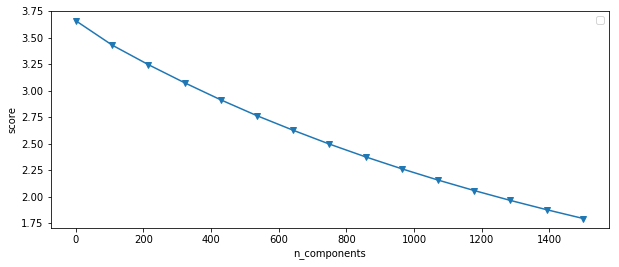

In [30]:
plt.figure(figsize=(10, 4))
plt.plot(components, rmse_scores, linestyle='-', marker='v');
plt.xlabel('n_components');
plt.ylabel('score');
plt.legend();


No handles with labels found to put in legend.


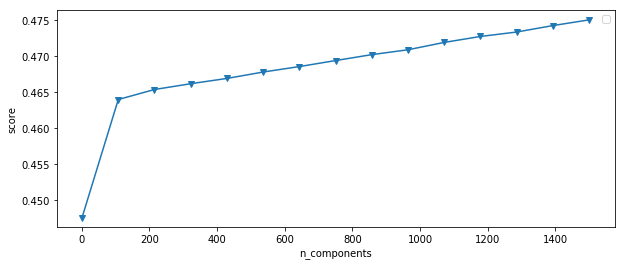

In [31]:
plt.figure(figsize=(10, 4))
plt.plot(components, ndcg_scores, linestyle='-', marker='v');
plt.xlabel('n_components');
plt.ylabel('score');
plt.legend();

**5. (3 балла)** Постройте рекомендации на основе user-based коллаборативной фильтрации. 
Предсказание модели $\hat{r}_{ui}$ вычисляйте по следующей формуле:
$$\hat{r}_{ui} = \bar{r}_{u} + \frac{\sum_{v \in U(u)} w_{uv} (r_{vi} - \bar{r}_v)}{\sum_{v \in U(u)} w_{uv}},$$
где $\bar{r}_u$ — средний ретинг пользователя $u$, $w_{uv}$ — мера сходства пользователей $u$ и $v$, $U(u) = \{ v \in U \, | \, w_{uv} > \alpha\}$ — коллаборация пользователя $u$. 

Значение параметра $\alpha$ возьмите равным 0.9.

Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке.

In [62]:
alpha = 0.9
matrix_for_training = train_matrix + valid_matrix

In [63]:
sums_of = matrix_for_training.sum(axis=1)
number_of_people = matrix_for_training.astype(bool).sum(axis=1)
means = sums_of / number_of_people

In [64]:
for i, mean in enumerate(means):
            if str(mean) == 'nan':
                means[i] = np.nanmean(means)

In [65]:
distances_matrix = 1 / (1 + np.sqrt(np.dot(matrix_for_training, matrix_for_training.T)))

In [66]:
suitable = []
for i in range(distances_matrix.shape[0]):
    suitable_user = []
    for j in range(distances_matrix.shape[1]):
        if distances_matrix[i, j] > alpha and j!= i:
            suitable_user.append(j)
    suitable.append(suitable_user)

In [67]:
result_matrix = sparse.csr_matrix(matrix_for_training.shape)

In [68]:
for i, j in zip(test_matrix.nonzero()[0],test_matrix.nonzero()[1]):
    nominator = 0
    denominator = np.sum(suitable[i]) + 1
    nominator = np.sum([distances_matrix[i, suit] * (matrix_for_training[suit, j] - means[suit]) for suit in suitable[i]])
    result_matrix[i,j] = means[i] + nominator/denominator

C:\Users\Gleb\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [69]:
rmse_score(test_matrix,result_matrix)

0.84879320820836923

In [70]:
ndcg_score(test_matrix,result_matrix)

0.44470648823788783

**6. (1 балл)** Какой метод оказался лучше по каким метрикам? Почему?

* Лучшим методом по метрике RMSE оказался user-based CF. Это происходит из-за того, что SVD находит лучшее приближение разреженной матрицы по евклидовой норме, на него оказыают влияния нулевые значения. Однако в тестовой выборке на месте нулей стоят уже оценки, то есть получается, что указанные в начале нули воспринимаютс за информацию, коей они не несут.

* По метрике nDCG чуть лучше себя проявил SVD. Это происходит из-за того, что метрика учитывает лишь то, как отранжированы объекты.

**7. (1 балл)** Приведите достоинства и недостатки используемых метрик. Какие еще метрики можно было бы использовать для решения задачи? Приведите примеры других постановок задачи, как в этом случае можно было бы оценить качество?

##### Метрика RMSE
* В основе метрики для определенного количества релевантных предметов лежит оценка предсказанных значений
* Метрика не учитыает порядок рекомендаций

##### Метрика NDCG
* Главными ее достоинствами является то, что метрика учитывает порядок рекомендаций и количество релевантных предметов
* Информация о том, насколько хорошо модель предсказывает оценку пользователя, не используется

#### Другие метрики

* **MAP@k (Mean Average Precision)**:<br/>$$MAP=\frac{1}{|U|}\sum_{u \in U}{\frac{1}{k}\sum_{i=1}^{k}{rel(u,i)P\text{@}k(u)}}.$$<br/>Плюсы и минусы метрики такие же, как и у метрики nDCG.